# **Project Name**    - Online Retail Customer Segmentation



##### **Project Type**    - Unsupervised ML
##### **Contribution**    - Team
##### **Team Member 1 -** Pranay Kuthe
##### **Team Member 2 -** Vipil Khapre

# **Project Summary -**

In this project, your task is to identify major customer segments on a
transnational data set which contains all the transactions occurring between
01/12/2010 and 09/12/2011 for a UK-based and registered non-store online
retail.The company mainly sells unique all-occasion gifts. Many customers of
the company are wholesalers

Customer segmentation is an important process for any retail business as it helps in understanding customer behavior, preferences, and needs. Online retail customer segmentation can be achieved by analyzing customer data such as purchase history, website behavior, demographics, and social media engagement.

# **Project Statement -**

**The objective of this project is to develop a customer segmentation model for an online retail business in order to gain valuable insights into the customer base and implement targeted strategies to enhance customer satisfaction, increase sales, and optimize marketing efforts.**

# **GitHub Link -**

https://github.com/pmkuthe/Online_Retail_Customer_Segmentation

# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [103]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)

plt.style.use('ggplot')

### Dataset Loading

In [104]:
from google.colab import drive
drive.mount('/content/drive')
# Load Dataset
df = pd.read_excel('/content/drive/MyDrive/DATA SCIENCE/Capstone Projects/Python/Online Retail Customer Segmentation/Online Retail (2).xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# # Load Dataset
# df = pd.read_excel('E:\Study\ALMABETTER\ML_Projects\Online Retail Customer Segmentation\Online Retail.xlsx')

In [106]:
preserved_data = df.copy() # Creating a copy for the dataset

### Dataset First View

In [107]:
# Dataset First Look
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Dataset Rows & Columns count

In [108]:
# Dataset Rows & Columns count
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns available in the dataset")

There are 541909 rows and 8 columns available in the dataset


### Dataset Information

In [109]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Duplicate Values

In [110]:
# Dataset Duplicate Value Count
df.duplicated().sum()

5268

In [111]:
# Removing duplicates
df.drop_duplicates(inplace = True)

In [112]:
# Checking the if is there any duplicate values left after droping the duplicate values
df.duplicated().sum()

0

#### Missing Values/Null Values

In [113]:
# Missing Values/Null Values Count
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

<Axes: >

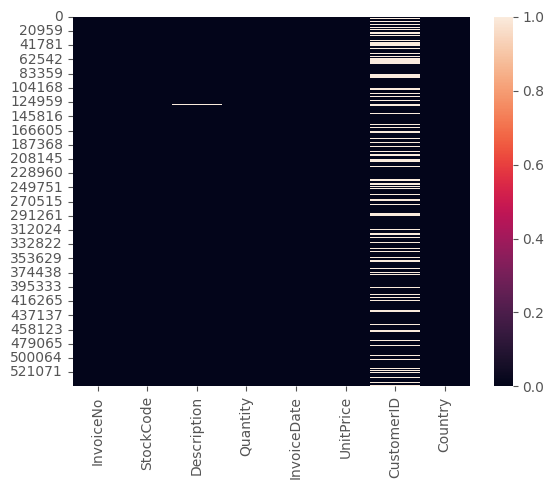

In [114]:
# Visualizing the missing values again with the help of heatmap
sns.heatmap(df.isna())

##### What did you know about your dataset?

The code generates a heatmap using Seaborn to visualize missing data in your dataset. This visualization helps identify patterns of missing values, assess data completeness, and decide on data cleaning strategies. It offers a quick overview of where data gaps exist, aiding in the initial steps of data preprocessing and quality improvement for your analysis.


Percentage of customers missing:  25.16 %

Check if InvoiceNo for Null Customer ID exist in cases where Customer ID is present for filling CustomerID Nulls


- No such cases present as empty dataframe is returned

In [115]:
null_id_invoices = df[df.CustomerID.isnull()]["InvoiceNo"].drop_duplicates().tolist()
print("Invoices count with Null Customer ID", len(null_id_invoices))

### Check if InvoiceNo in Null CustomerID dataframe exist in Non-Null Customer ID Dataframe
df[~df.CustomerID.isnull()][df.InvoiceNo.isin(null_id_invoices)]


Invoices count with Null Customer ID 3710


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Since the customer ID's are missing, I assume these orders were not made by the customers already in the data set because those customers already have ID's. I also don't want to assign these orders to those customers because this would alter the insights I draw from the data. Instead of dropping the null CustomerID values which amounts to ~25% of data, let's assign those rows a unique customer ID per order using InvoiceNo. This will act as a new customer for each unique order.



Check if InvoiceNo has unique mapping with Customer ID so that each InvoiceNo corresponding to Null CustomerID can be assigned as New Customer



In [116]:
df.groupby(['InvoiceNo'])['CustomerID'].nunique().reset_index(name='nunique').sort_values(['nunique'], ascending=False).head(5)

,InvoiceNo,nunique
0,536365,1
16915,571200,1
16924,571215,1
16923,571214,1
16922,571213,1


On sorting descending, this data shows that each Invoice relates to maximum of 1 Customer

Creating NewID column and Assigning to InvoiceNo wherever CustomerID is null

In [117]:
df['NewID'] = df['CustomerID']
df.loc[df['CustomerID'].isnull(), ['NewID']] = df['InvoiceNo']

#Remove all non digits from column NewID (Since Invoice can contains "C" referring to cancellations)
df['NewID'] = df['NewID'].astype(str).str.replace('\D+', '')

#Convert to integer
df['NewID'] = pd.to_numeric(df['NewID'])

### Check if presnt customerIds and New Ids have any common values since it would create alter actual Customer Insights
customer = df['CustomerID'].nunique()
null_invoices = df[df.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids = df['NewID'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)
print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3710
Number of Customers + Number of Orders where CustomerID in Null: 8082
Number of New ID's: 8082


Since both values equal, we know all the different orders that didn't have a customer ID got assigned unique NewID and no duplicates were created



In [118]:
df.drop(['CustomerID'], axis=1, inplace = True)
df = df.rename(columns = {'NewID': 'CustomerID'})
df.dropna(inplace = True)

##### Converting InvoiceDate column from object type to datetime and checking first and last dates


In [119]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
print("Minimum Invoice Date", min(df["InvoiceDate"]))
print("Maximum Invoice Date", max(df["InvoiceDate"]))

Minimum Invoice Date 2010-12-01 08:26:00
Maximum Invoice Date 2011-12-09 12:50:00


## ***2. Understanding Your Variables***

In [120]:
# Dataset Columns
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'Country', 'CustomerID'],
      dtype='object')

In [121]:
# Dataset Describe
df.describe()

,Quantity,UnitPrice,CustomerID
count,535187.000000,535187.000000,535187.000000
mean,9.671593,4.645242,253964.894459
std,219.059056,97.364810,176159.542227
min,-80995.000000,-11062.060000,123460.000000
25%,1.000000,1.250000,143560.000000
50%,3.000000,2.080000,162420.000000
75%,10.000000,4.130000,182830.000000
max,80995.000000,38970.000000,581498.000000


### Variables Description

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides

### Check Number of Unique Values for each variable.

In [122]:
# Check No. of Unique Values for each variable.
for i in df.columns:
  print("No. of unique values in",i,"is",df[i].nunique())

No. of unique values in InvoiceNo is 24446
No. of unique values in StockCode is 3958
No. of unique values in Description is 4223
No. of unique values in Quantity is 671
No. of unique values in InvoiceDate is 22309
No. of unique values in UnitPrice is 1630
No. of unique values in Country is 38
No. of unique values in CustomerID is 6628


### Creating new columns

In [123]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df["year"]  = df["InvoiceDate"].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day']   = df['InvoiceDate'].dt.day
df["hour"]  = df["InvoiceDate"].dt.hour

The time part of the column is not used because, time of the day does not influence the orders to a large extent.

In [124]:
# Creating a new feature 'TotalAmount' by multiplying Quantity and UnitPrice
df['TotalAmount']= df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34


In [125]:
# Creating a new feature 'TimeType' based on hours to define whether its Morning,Afternoon or Evening
df['TimeType'] = np.where((df["hour"]>5)&(df["hour"]<18), np.where(
                           df["hour"]<12, 'Morning','Afternoon'),'Evening')

In [126]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535187 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535187 non-null  object        
 1   StockCode    535187 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     535187 non-null  int64         
 4   InvoiceDate  535187 non-null  datetime64[ns]
 5   UnitPrice    535187 non-null  float64       
 6   Country      535187 non-null  object        
 7   CustomerID   535187 non-null  int64         
 8   year         535187 non-null  int64         
 9   Month        535187 non-null  int64         
 10  Day          535187 non-null  int64         
 11  hour         535187 non-null  int64         
 12  TotalAmount  535187 non-null  float64       
 13  TimeType     535187 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 61.2+ MB


It is known that some of the orders have been cancelled, the invoice numbers of these orders start with a 'C'. The cancelled orders are also removed.

In [128]:
# Converting the column to a string type to detect 'C'
df['InvoiceNo'] = df['InvoiceNo'].apply(str)

In [129]:
df['Cancelled'] = df['InvoiceNo'].apply(lambda x: 'Yes' if 'C' in x else 'No' )

In [130]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType,Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning,No
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,No
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning,No
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,No
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,No


In [131]:
df.drop(df[df['Cancelled']=='Yes'].index, inplace=True)

In [132]:
df[df['Cancelled']=='Yes']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType,Cancelled


In [133]:
df.drop('Cancelled', axis=1,inplace=True)

In [134]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


This shows that quantity is negative when any order was cancelled. Removed cancellations data since they only make upto ~2% of data



#### Stock code and Item description represent the same thing, but item description describes it more clearly. Hence, we can drop the stock code.

In [135]:
# Dropping Stock Code column
df.drop('StockCode', axis = 1, inplace = True)

In [136]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


In [137]:
df.describe()

,Quantity,UnitPrice,CustomerID,year,Month,Day,hour,TotalAmount
count,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000
mean,10.365655,3.872616,255502.775229,2010.921783,7.553149,15.025494,13.074682,20.192546
std,160.075723,42.021233,176980.991302,0.268513,3.508143,8.661265,2.442717,272.280672
min,-9600.000000,-11062.060000,123460.000000,2010.000000,1.000000,1.000000,6.000000,-11062.060000
25%,1.000000,1.250000,143820.000000,2011.000000,5.000000,7.000000,11.000000,3.900000
50%,3.000000,2.080000,162750.000000,2011.000000,8.000000,15.000000,13.000000,9.920000
75%,11.000000,4.130000,536876.000000,2011.000000,11.000000,22.000000,15.000000,17.700000
max,80995.000000,13541.330000,581498.000000,2011.000000,12.000000,31.000000,20.000000,168469.600000


#### In the data cleaning procedure -
* Null Values were removed
* Cancelled orders were removed
* Invoice Date column was split to form seperate date, month and year columns
* Outliers were removed
* Columns such as invoice date, stock code have been removed

## 3. ***Data Wrangling***

### Data Wrangling Code

In [138]:
# Checking top Product name from the dataset
Description_df=df['Description'].value_counts().reset_index()
Description_df.rename(columns={'index': 'Product_Name'}, inplace=True)
Description_df.rename(columns={'Description': 'Count'}, inplace=True)
Description_df.head() #top 5 Product Name

,Product_Name,Count
0,WHITE HANGING HEART T-LIGHT HOLDER,2315
1,JUMBO BAG RED RETROSPOT,2112
2,REGENCY CAKESTAND 3 TIER,2009
3,PARTY BUNTING,1700
4,LUNCH BAG RED RETROSPOT,1581


In [139]:
#bottom 5 Product name
Description_df.tail()

,Product_Name,Count
4202,TINY CRYSTAL BRACELET RED,1
4203,4 GOLD FLOCK CHRISTMAS BALLS,1
4204,ZINC STAR T-LIGHT HOLDER,1
4205,BLUE GINGHAM ROSE CUSHION COVER,1
4206,"PAPER CRAFT , LITTLE BIRDIE",1


In [140]:
# Checking top Country name from the dataset
country_df = df['Country'].value_counts().reset_index()
country_df.rename(columns = {'index': 'Country_Name'}, inplace=True)
country_df.rename(columns = {'Country': 'Count'}, inplace=True)
country_df.head() #top 5 country name

,Country_Name,Count
0,United Kingdom,481025
1,Germany,9027
2,France,8393
3,EIRE,7883
4,Spain,2480


In [141]:
#bottom 5 country name
country_df.tail()

,Country_Name,Count
33,Lithuania,35
34,Brazil,32
35,Czech Republic,25
36,Bahrain,18
37,Saudi Arabia,9


In [142]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

In [143]:
# Creat a dataframe without cancelled ordered
temp_df = df[~df['InvoiceNo'].astype(str).str.contains('C')]

In [144]:
# Group the dataset by Description column and calculate the sum of the quantity sold for each product
# Select the top 10 products
product = temp_df.groupby('Description')['Quantity'].sum().sort_values(ascending = False).head(10)

# Create the dataframe containing the top 10 selling products
top_product = pd.DataFrame({'Product': product.index, 'Quantity Sold': product.values})
top_product


,Product,Quantity Sold
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,78033
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54951
3,JUMBO BAG RED RETROSPOT,48375
4,WHITE HANGING HEART T-LIGHT HOLDER,37876
5,POPCORN HOLDER,36749
6,PACK OF 72 RETROSPOT CAKE CASES,36396
7,ASSORTED COLOUR BIRD ORNAMENT,36362
8,RABBIT NIGHT LIGHT,30739
9,MINI PAINT SET VINTAGE,26633


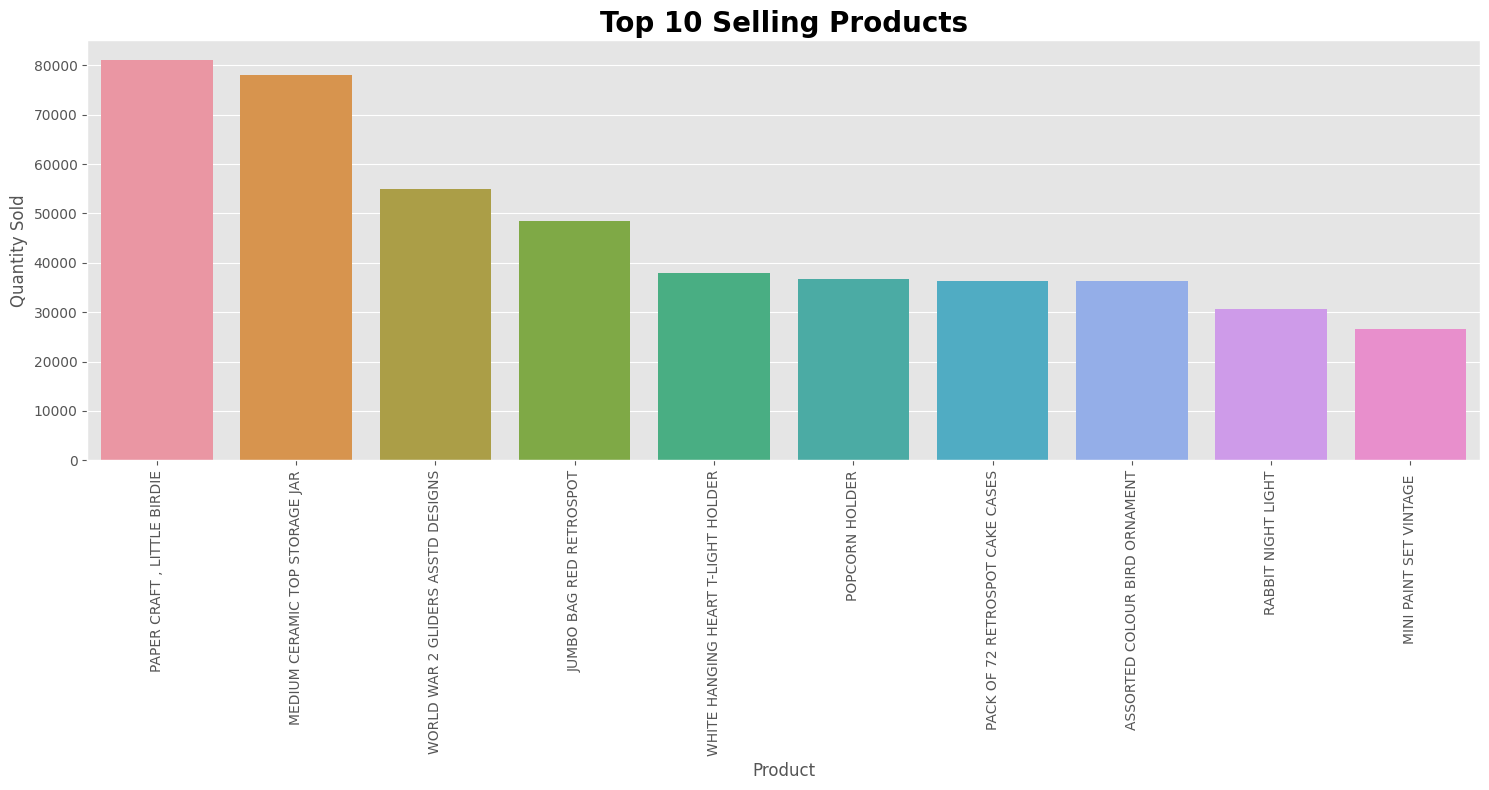

In [145]:
import random
# Generate a list of random colors
#color = [tuple(random.random() for i in range(3)) for j in range(len(top_product))]

# Plot bar chart
plt.figure(figsize = (15, 8))
sns.barplot(top_product, x = 'Product', y = 'Quantity Sold')

# Set the title
plt.title('Top 10 Selling Products', size=20, fontweight='bold')
#plt.xlabel('Product', size = 15)
#plt.ylabel('Quantity Sold', size = 15)

# Rotate the x-axis labels
plt.xticks(rotation = 90)

# Display the chart
plt.tight_layout()


##### 1. Why did you pick the specific chart?

I chose a bar chart because it's suitable for comparing the top-selling products, as it allows for a clear visual comparison of quantities sold for each product. The horizontal bars make it easy to see which products are the most popular.

##### 2. What is/are the insight(s) found from the chart?

The chart reveals the top 10 selling products, providing insights into which products are in high demand. It allows you to identify the best-selling items based on the quantity sold.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Yes, the gained insights can help create a positive business impact. By knowing the top-selling products, a business can make informed decisions such as focusing on marketing, ensuring product availability, or optimizing pricing strategies for these products. This can lead to increased sales and revenue.

The insights obtained from the chart are generally positive, as they highlight the best-selling products. However, if the chart showed that a significant portion of the products were not selling well, it could be considered a negative insight. In such a case, the business may need to reevaluate its inventory or marketing strategies for those underperforming products.

#### Chart - 2

In [146]:
# Create dataframe containing only top 5 customers
top_customers = temp_df['CustomerID'].value_counts().sort_values(ascending = False).reset_index().rename(columns = {'index' : 'CustomerID', 'CustomerID': 'Count'}).head(5)

top_customers

,CustomerID,Count
0,178410,7676
1,149110,5672
2,140960,5111
3,127480,4413
4,146060,2677


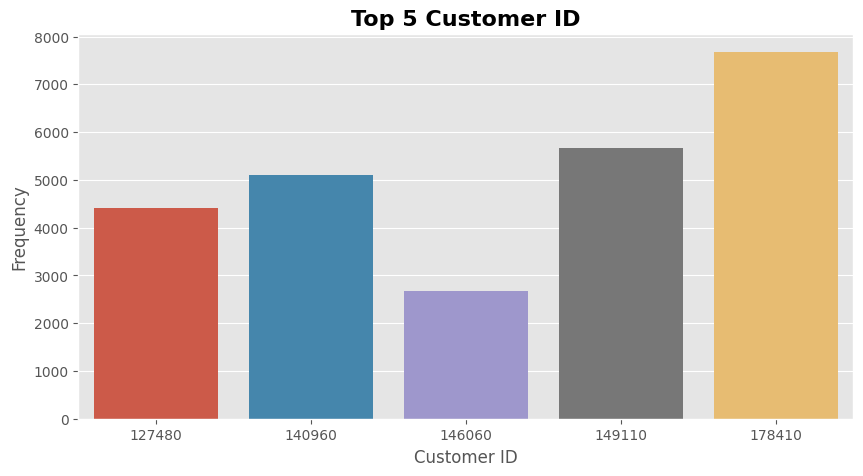

In [147]:
plt.figure(figsize = (10, 5))

# Create the bar plot
sns.barplot(data = top_customers, x = 'CustomerID', y = 'Count')

# Add labels and a title
plt.title('Top 5 Customer ID', fontsize = 16, fontweight = 'bold')
plt.xlabel('Customer ID')
plt.ylabel('Frequency');


##### 1. Why did you pick the specific chart?

The specific chart chosen is a bar chart because it effectively represents the top 5 customers in a clear and straightforward manner. A bar chart is suitable for visualizing and comparing the frequency (or count) of the top customers, making it easy to identify the most frequent customers.

##### 2. What is/are the insight(s) found from the chart?

- The chart reveals that the Customer IDs on the x-axis are the top 5 most frequent customers.
- It shows the frequency (count) of their transactions on the y-axis.
- The chart helps in identifying the most loyal or valuable customers.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Yes, the gained insights can potentially have a positive business impact.
Identifying the top customers allows the business to focus on retaining and providing excellent service to these high-value customers.
Tailoring marketing strategies and promotions to cater to these customers can boost sales and customer loyalty.

There are no inherent negative growth insights from this chart alone.
However, if the analysis of these top customers reveals issues like declining purchase frequency or negative feedback, it could lead to negative growth.
To understand such negative impacts, additional analysis beyond this chart is necessary.

#### Chart - 3

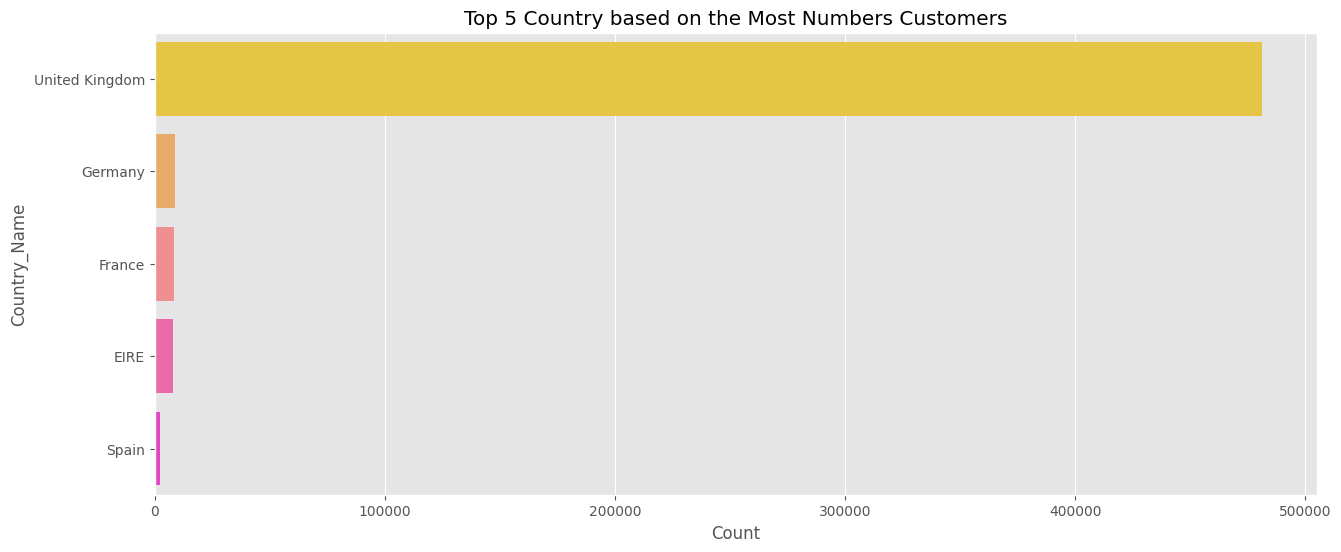

In [148]:
#plot top 5 country name
plt.figure(figsize=(15,6))
plt.title('Top 5 Country based on the Most Numbers Customers')
sns.barplot(x='Count',y='Country_Name',data=country_df[:5], palette='spring_r');

*From this graph we can see that most of the customers are from United Kingdom that make sense aas company is from UK bases after that we have Germany ,France ,EIRE and Spain*

##### 1. Why did you pick the specific chart?

I chose a bar chart because it's effective for comparing and visualizing the top countries with the most customers. The horizontal bars make it easy to see the differences between countries.

##### 2. What is/are the insight(s) found from the chart?

The chart shows that the United Kingdom has the highest number of customers, followed by Germany, France, EIRE, and Spain. This provides insights into the distribution of customers by country.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

Yes, the gained insights can help create a positive business impact. Knowing where the majority of customers are located can inform marketing and customer engagement strategies. However, it's essential to consider that if there's overreliance on one country (e.g., the UK), it might pose a risk in case of economic downturns or other challenges, so diversification might be needed to mitigate potential negative impacts.

#### Chart - 4

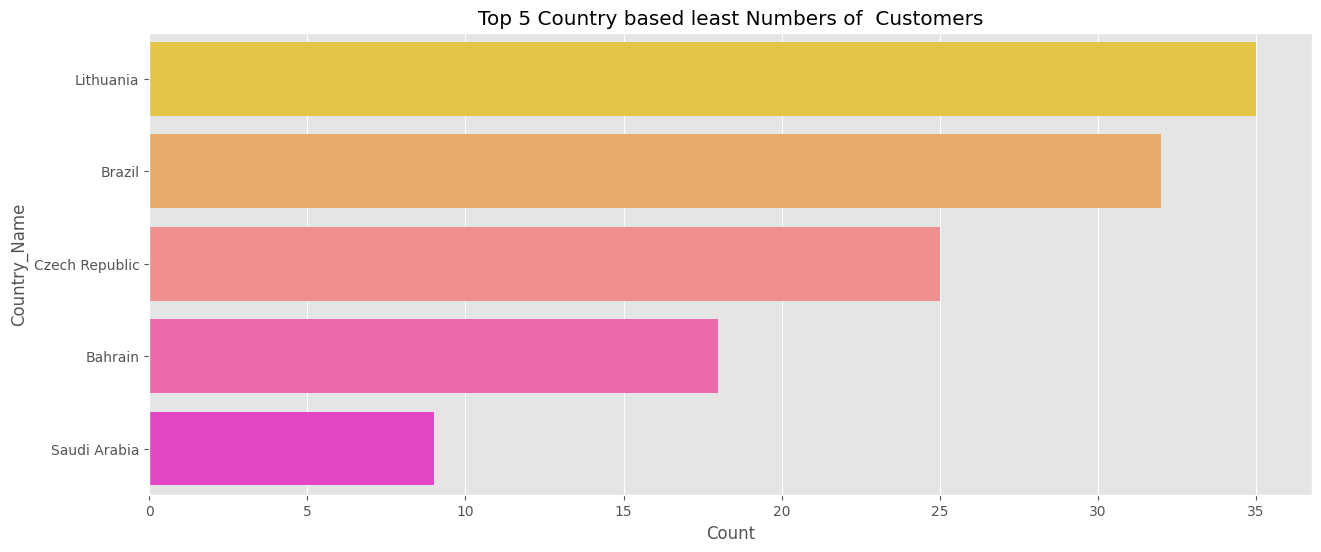

In [149]:
#plot bottom 5 country name
plt.figure(figsize=(15,6))
plt.title('Top 5 Country based least Numbers of  Customers')
sns.barplot(x='Count',y='Country_Name',data=country_df[-5:], palette='spring_r');

##### 1. Why did you pick the specific chart?

I chose a bar chart because it's effective for visualizing the top 5 countries with the least number of customers, making it easy to compare customer counts across these countries.

##### 2. What is/are the insight(s) found from the chart?

- The chart shows the top 5 countries with the least number of customers.
- From the chart, we can see that these countries have a significantly lower number of customers compared to the others.
- This may indicate that there is less market presence or demand for the products in these countries.
- It could be an opportunity for the business to focus on marketing and expanding its customer base in these countries to increase sales.
- The chart helps identify regions where the company might need to invest more in customer acquisition and retention strategies.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

The gained insights may not directly create a positive business impact on their own, but they can inform further analysis. For example, identifying countries with fewer customers might prompt businesses to explore opportunities to expand their customer base in those regions.

Negative growth is not directly implied by the chart. However, it's essential to understand that having fewer customers in certain countries could mean missed market opportunities. To determine if it leads to negative growth, more data and analysis, including revenue and profitability, would be needed.

#### Chart - 5

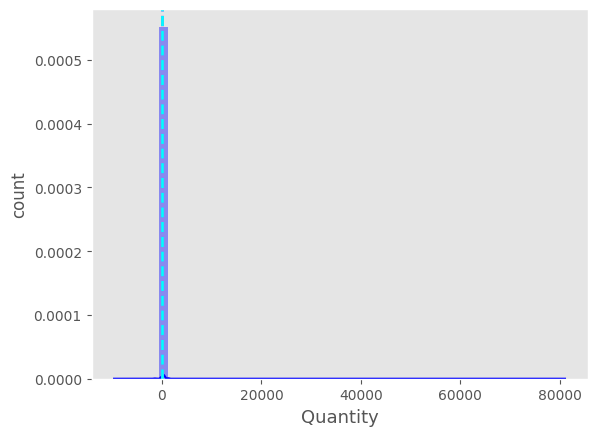

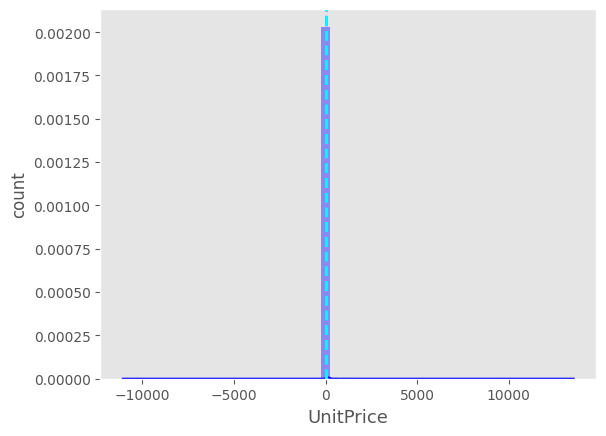

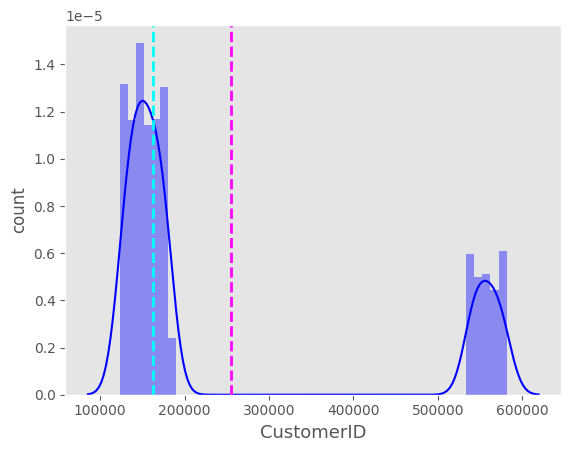

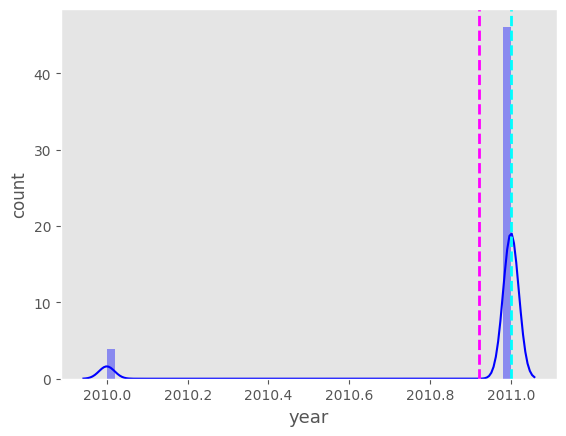

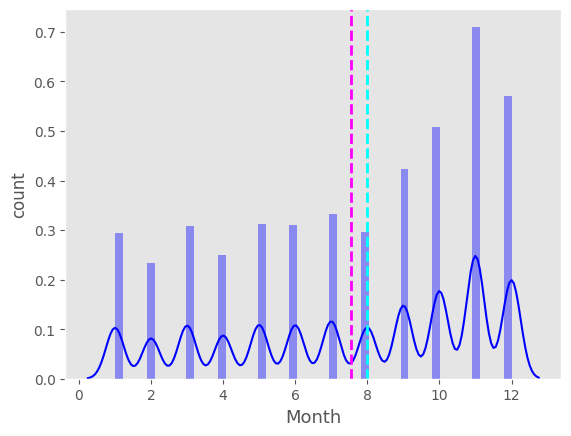

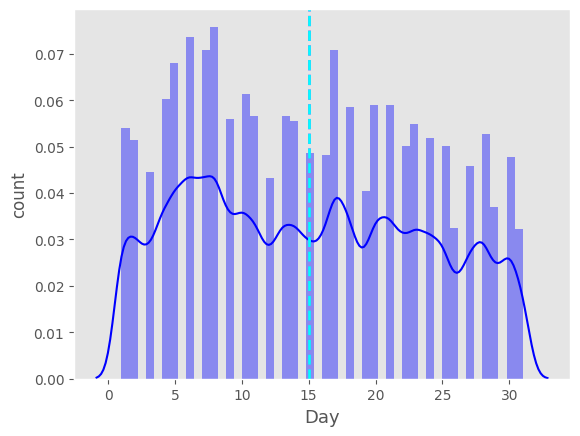

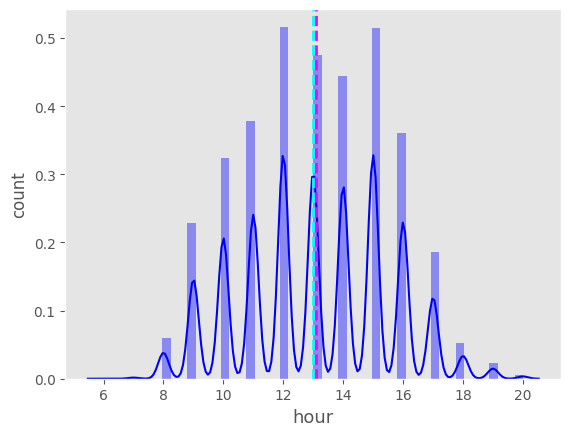

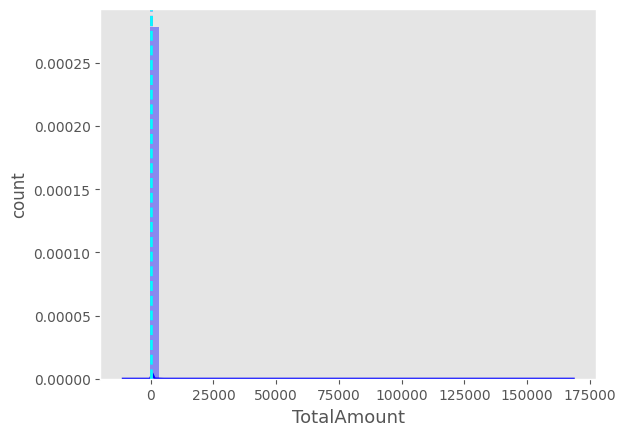

In [150]:
# checking distribution for numerical features
for col in df.select_dtypes([int,float]).columns:

    sns.distplot(df[col], color='blue')

   #PLotting the mean and median
    plt.axvline(df[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(df[col].median(), color='cyan', linestyle='dashed', linewidth=2)
    plt.xlabel(col, fontsize=13)
    plt.ylabel('count')
    plt.grid()
    plt.show()

##### 1. Why did you pick the specific chart?

I picked a distribution plot (histogram) for numerical features because it provides a clear visual representation of the data's distribution, making it easy to spot patterns and outliers.

##### 2. What is/are the insight(s) found from the chart?

The insights from the chart include the central tendency (mean and median) and the shape of the distribution. This helps us understand the typical values and the data's spread.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

The gained insights can help create a positive business impact. For example, if the mean and median of a relevant numerical feature represent high sales values, it could indicate popular products or customer preferences. However, these insights alone may not be sufficient to identify negative growth or issues; additional analysis and context are needed to make such determinations.

#### Chart - 6

<Axes: >

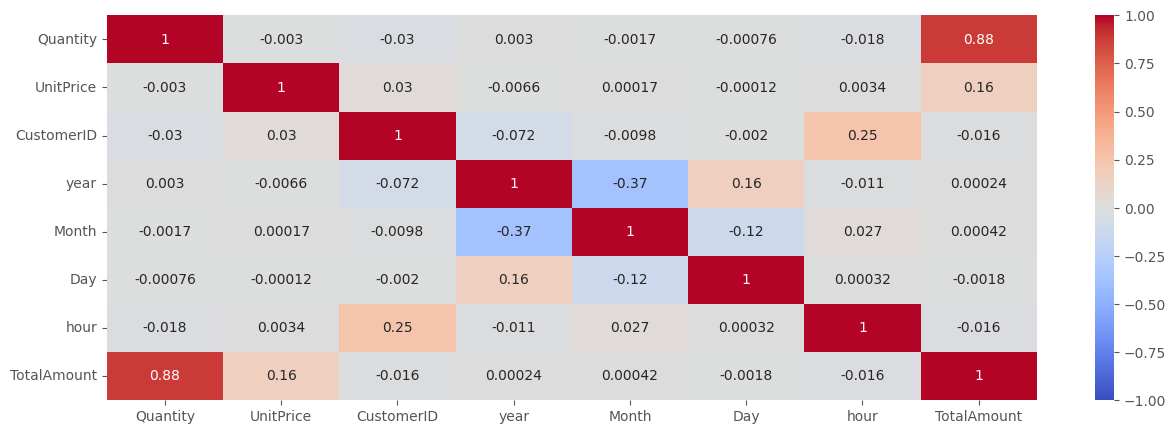

In [151]:
# Cecking correlation
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',vmin=-1,vmax=1)

##### 1. Why did you pick the specific chart?

The specific chart chosen is a heatmap, which is commonly used for visualizing the correlation between variables in a dataset. It's appropriate for understanding how different numerical features are related to each other.

##### 2. What is/are the insight(s) found from the chart?

The insights found from the chart are the correlation coefficients between the numerical columns in the dataset. The values in the cells of the heatmap represent the strength and direction of the correlation between pairs of variables. Positive values indicate a positive correlation, negative values indicate a negative correlation, and values close to zero indicate a weak or no correlation.

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

The gained insights can help create a positive business impact by identifying relationships between variables. For example, if high correlation is found between certain features, it could indicate that changes in one variable are associated with changes in another. This information can guide data-driven decision-making, such as optimizing inventory management or pricing strategies.

Negative insights, in this context, are not necessarily negative for the business but indicate that the variables are inversely related. This information can also be valuable. For instance, if a business observes a negative correlation between product returns and customer satisfaction, it may imply that improving customer satisfaction could reduce returns, which could be a positive business impact.

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing

--> Let's define three hypothetical statements and then perform hypothesis testing for each one using the dataset. For the sake of this example, let's assume a significance level (alpha) of 0.05 for all tests.



*   Statement 1: To determine if there is a significant difference in the average "TotalAmount" of sales during the morning compared to the afternoon.
*   Statement 2: Determine if the average unit prices of "WHITE HANGING HEART T-LIGHT HOLDER" and "WHITE METAL LANTERN" differ significantly (H1) or remain the same (H0).
*   Statement 3: Investigating sales disparities across countries using a Two-Sample T-Test to discern differences in product Quantity between the United Kingdom and other nations.

### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement 1: To determine if there is a significant difference in the average "TotalAmount" of sales during the morning compared to the afternoon

Null Hypothesis (H0): The average "TotalAmount" for the "TimeType" in the morning is the same as in the afternoon.

Alternative Hypothesis (H1):The average "TotalAmount" for the "TimeType" in the morning is different from that in the afternoon

#### 2. Perform an appropriate statistical test.

In [152]:
from scipy import stats

morning = df[df['TimeType'] == 'Morning']['TotalAmount']
afternoon = df[df['TimeType'] == 'Afternoon']['TotalAmount']

t_stat, p_value = stats.ttest_ind(morning, afternoon)

# Conclusion
if p_value < 0.05:
    result = "Reject the null hypothesis"
else:
    result = "Fail to reject the null hypothesis"

print(f"p-value: {p_value}")
print(f"We {result}.")

p-value: 7.8674250110875725e-31
We Reject the null hypothesis.


***Conclusion*** : There is a significant difference in average TotalAmount between Morning and Afternoon

##### Which statistical test have you done to obtain P-Value?

We performed an Independent Two-Sample T-Test to obtain the P-value.

##### Why did you choose the specific statistical test?

We chose the Independent Two-Sample T-Test because it is appropriate for comparing the means of two independent groups, in this case, "Morning" and "Afternoon." This test helps determine if there is a significant difference in the "TotalAmount" between these two time categories, providing valuable insights into potential variations in sales trends throughout the day.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement 2:  Determine if the average unit prices of "WHITE HANGING HEART T-LIGHT HOLDER" and "WHITE METAL LANTERN" differ significantly (H1) or remain the same (H0).

Null Hypothesis (H0):  The average unit price of "WHITE HANGING HEART T-LIGHT HOLDER" is the same as the average unit price of "WHITE METAL LANTERN."

Alternative Hypothesis (H1):  The average unit price of "WHITE HANGING HEART T-LIGHT HOLDER" is different from the average unit price of "WHITE METAL LANTERN."

#### 2. Perform an appropriate statistical test.

In [153]:
heart_holder_prices = df[df['Description'] == 'WHITE HANGING HEART T-LIGHT HOLDER']['UnitPrice']
lantern_prices = df[df['Description'] == 'WHITE METAL LANTERN']['UnitPrice']

t_stat, p_value = stats.ttest_ind(heart_holder_prices, lantern_prices)

# Conclusion
if p_value < 0.05:
    result = "Reject the null hypothesis"
else:
    result = "Fail to reject the null hypothesis"

print(f"p-value: {p_value}")
print(f"We {result}.")

p-value: 4.219472707093368e-92
We Reject the null hypothesis.


***Conclusion*** : We reject the null hypothesis as the p-value is less than 0.05, indicating a statistically significant difference in the average unit prices between "WHITE HANGING HEART T-LIGHT HOLDER" and "WHITE METAL LANTERN."

##### Which statistical test have you done to obtain P-Value?

the statistical test used to obtain the p-value is the independent two-sample t-test (ttest_ind) from the 'scipy.stats' library.

##### Why did you choose the specific statistical test?

The specific statistical test, the independent t-test, was chosen because it is suitable for comparing the means of two independent groups (in this case, the unit prices of two different products) to determine if there is a statistically significant difference between them.

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement 3:  Investigating sales disparities across countries using a Two-Sample T-Test to discern differences in product Quantity between the United Kingdom and other nations.

Null Hypothesis (H0):  The "Quantity" of products sold in the United Kingdom is the same as the "Quantity" of products sold in other countries.

Alternative Hypothesis (H1):The "Quantity" of products sold in the United Kingdom is different from the "Quantity" of products sold in other countries.  

#### 2. Perform an appropriate statistical test.

In [154]:
uk_sales = df[df['Country'] == 'United Kingdom']['Quantity']
other_country_sales = df[df['Country'] != 'United Kingdom']['Quantity']

t_stat, p_value = stats.ttest_ind(uk_sales, other_country_sales)

# Conclusion
if p_value < 0.05:
    result = "Reject the null hypothesis"
else:
    result = "Fail to reject the null hypothesis"

print(f"p-value: {p_value}")
print(f"We {result}.")

p-value: 7.309725789293177e-46
We Reject the null hypothesis.


***Conclusion*** : There is a significant difference in the Quantity of products sold between the United Kingdom and other countries.

##### Which statistical test have you done to obtain P-Value?

We conducted an Independent Two-Sample T-Test to obtain the P-value.

##### Why did you choose the specific statistical test?

We selected the Independent Two-Sample T-Test because it is suitable for comparing the means of two independent groups (United Kingdom and other countries). This test helps determine if there is a significant difference in the Quantity of products sold between these groups, allowing us to assess cross-country sales variations.






In [155]:
df1 = df.copy() # Creating a copy for the dataset before performing ML

In [156]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


### From the EDA section some assumptions can be made

*   Small to medium quantities of each item are purchased more.
*   Unit price for most products is low.
*   Last quarter of the year has more orders maybe due to the holiday season.
*   As customers buy in large quantites, it is a volume based business.


## 3. **Data Transformation**

### For the purpose of this project - Recency, Frequency and Monetory (RFM) analysis shall be conducted. On the basis of these 3 factors, customers can be classified into different groups. They can be catered by the business depending on the cluster they belong to.

**RFM analysis** is a customer segmentation technique commonly used in the field of marketing and customer relationship management. RFM stands for Recency, Frequency, and Monetary Value, which are three key dimensions used to evaluate customer behavior and segment customers based on their purchasing patterns. Here's an explanation of each component:

- Recency (R): Recency refers to the time elapsed since a customer's last purchase. It measures how recently a customer has interacted with the business. Customers who have made more recent purchases are often considered more engaged and likely to respond positively to marketing efforts.

- Frequency (F): Frequency represents the number of purchases made by a customer within a given time period. It measures the level of customer activity or engagement. Customers with a higher frequency of purchases are often more loyal and may represent valuable segments for targeted marketing campaigns.

- Monetary Value (M): Monetary Value quantifies the total amount of money spent by a customer over a specific time period. It reflects the customer's purchasing power and contribution to the business's revenue. Customers with higher monetary value are often considered more valuable and may receive special offers or incentives to encourage repeat purchases.

## Recency

**Recency = Latest InvoiceDate - Last InoviceData**

In [157]:
df['Date'] = df['InvoiceDate'].dt.date

In [158]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType,Date
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning,2010-12-01
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,2010-12-01
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning,2010-12-01
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,2010-12-01
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,2010-12-01


In [159]:
# Group the dataset by customerID and find the most recent purchase date for each customer
recency_df = df.groupby('CustomerID')['Date'].max().reset_index().rename(columns = {'Date': 'LastPurchaseDate'})

# Display the first few rows of the dataframe to inspect the results
recency_df.head()

,CustomerID,LastPurchaseDate
0,123460,2011-01-18
1,123470,2011-12-07
2,123480,2011-09-25
3,123490,2011-11-21
4,123500,2011-02-02


In [160]:
# Get the latest date in the dataset
latest_date = df['Date'].max()

print(latest_date)

2011-12-09


In [161]:
# Calculate the recency of each customer's last purchase
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x : (latest_date - x).days)

# Display the first 10 rows of the recency dataframe
recency_df.head(10)

,CustomerID,LastPurchaseDate,Recency
0,123460,2011-01-18,325
1,123470,2011-12-07,2
2,123480,2011-09-25,75
3,123490,2011-11-21,18
4,123500,2011-02-02,310
5,123520,2011-11-03,36
6,123530,2011-05-19,204
7,123540,2011-04-21,232
8,123550,2011-05-09,214
9,123560,2011-11-17,22


In [162]:
# Drop the 'LastPurchaseDate' column from the dataframe
recency_df.drop('LastPurchaseDate', axis = 1, inplace = True)

recency_df.head()

,CustomerID,Recency
0,123460,325
1,123470,2
2,123480,75
3,123490,18
4,123500,310


Now we have the recency attribute created e.g: Customer with ID = 12346 did his/her last purshace 325 days ago.

## **Frequency**

In [163]:
# Group the data by customer ID and count the number of invoices for each customer
frequency_df = df.groupby('CustomerID')['InvoiceNo'].count().reset_index().rename(columns = {'InvoiceNo': 'Frequency'})

# Display the first 10 rows of the dataframe to inspect the results
frequency_df.head(10)

,CustomerID,Frequency
0,123460,1
1,123470,182
2,123480,31
3,123490,73
4,123500,17
5,123520,85
6,123530,4
7,123540,58
8,123550,13
9,123560,59


## **Monetary Value**

In [164]:
# Group the data by customer ID and sum the total amount spent by each customer
monetary_df = df.groupby('CustomerID')['TotalAmount'].sum().reset_index().rename(columns = {'TotalAmount': 'MonetaryValue'})

monetary_df.head()

,CustomerID,MonetaryValue
0,123460,77183.60
1,123470,4310.00
2,123480,1797.24
3,123490,1757.55
4,123500,334.40


**The RFM dataframe combines recency, frequency, and monetary value information for each customer to provide a comprehensive overview of their behavior and spending habits.**

In [165]:
# Merge the recency and frequency dataframes on the customer ID column

tem_df = recency_df.merge(frequency_df, on = 'CustomerID')

tem_df.head()

,CustomerID,Recency,Frequency
0,123460,325,1
1,123470,2,182
2,123480,75,31
3,123490,18,73
4,123500,310,17


In [166]:
# Merge the monetary value and tem_df dataframe on the customer ID column
rfm_df = tem_df.merge(monetary_df, on = 'CustomerID')

rfm_df.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,123460,325,1,77183.60
1,123470,2,182,4310.00
2,123480,75,31,1797.24
3,123490,18,73,1757.55
4,123500,310,17,334.40


Customer with ID = 12346 has recency: 325 days, frequency:1, and monetary: 77183,60 £.

## **Customer segments with RFM Model**

The simplest way to create customers segments from RFM Model is to use **Quantiles**. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 555 possible combinations. So, we will use quartiles.

In [167]:
# Calculate quantiles for the RFM dataframe
quantiles = rfm_df[['Recency', 'Frequency', 'MonetaryValue']].quantile(q = [0.25, 0.5, 0.75])

quantiles

,Recency,Frequency,MonetaryValue
0.25,23.0,8.0,147.12
0.50,71.0,32.0,519.61
0.75,198.0,91.0,1476.28


In [168]:
# Convert quantile values to dictionary
quantiles_dict = quantiles.transpose().to_dict()

quantiles_dict

{0.25: {'Recency': 23.0, 'Frequency': 8.0, 'MonetaryValue': 147.12},
 0.5: {'Recency': 71.0, 'Frequency': 32.0, 'MonetaryValue': 519.61},
 0.75: {'Recency': 198.0, 'Frequency': 91.0, 'MonetaryValue': 1476.28}}

## **RFM Table & Score**

In [169]:

# Create RecencyScore column by dividing Recency into quartiles and assigning respective quantile labels
rfm_df['RecencyScore'] = pd.qcut(rfm_df['Recency'], q = [0, 0.25, 0.5, 0.75, 1], labels = list(range(4, 0, -1)))

# Create FrequencyScore column by dividing Frequency into quartiles and assigning respective quantile labels
rfm_df['FrequencyScore'] = pd.qcut(rfm_df['Frequency'], q=[0, 0.25, 0.5, 0.75, 1], labels=list(range(1, 5)))

# Create MonetaryScore column by dividing MonetaryValue into quartiles and assigning respective quantile labels
rfm_df['MonetaryScore'] = pd.qcut(rfm_df['MonetaryValue'], q=[0, 0.25, 0.5, 0.75, 1], labels=list(range(1, 5)))

In [170]:
# Show first 5 rows of the rfm_df dataframe
rfm_df.head()

,CustomerID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore
0,123460,325,1,77183.60,1,1,4
1,123470,2,182,4310.00,4,4,4
2,123480,75,31,1797.24,2,2,4
3,123490,18,73,1757.55,4,3,4
4,123500,310,17,334.40,1,2,2


In [171]:
# Concatenate the RecencyScore, FrequencyScore, and MonetaryScore columns into one RFMScore column
rfm_df['RFMScore'] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str) + rfm_df['MonetaryScore'].astype(str)

rfm_df.head()

,CustomerID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
0,123460,325,1,77183.60,1,1,4,114
1,123470,2,182,4310.00,4,4,4,444
2,123480,75,31,1797.24,2,2,4,224
3,123490,18,73,1757.55,4,3,4,434
4,123500,310,17,334.40,1,2,2,122


**Interpretation:**
- Best RecencyScore = 4 (most recently purchase)
- Best FrequencyScore = 4 (most frequently purchase)
- Best MonetaryScore = 4 (who spent the most)
- If the RFMScore of any customer is 444. His Recency is good, frequency is more and Monetary is more. So, he is the best customer.
- If the RFMScore of any customer is 111. His Recency is low, frequency is low and Monetary is low. So, he is the churning customer.
- If the RFMScore of any customer is 144. He purchased a long time ago but buys frequently and spends more and so on.
- Like this we can come up with number of segments for all combinations of RecencyScore, FrequencyScore and MonetaryScore based on our usecase.
- Higher the RFMScore, more valuable the customer is.

In [172]:
# Sort the dataframe by MonetaryValue in descending order and reset the index
rfm_df2 = rfm_df[rfm_df['RFMScore'] == '444'].sort_values('MonetaryValue', ascending = False)

In [173]:
rfm_df2.head(10)

,CustomerID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
1690,146460,1,2080,280206.02,4,4,4,444
4202,181020,0,431,259657.30,4,4,4,444
3729,174500,8,336,194390.79,4,4,4,444
1880,149110,1,5672,143711.17,4,4,4,444
1334,141560,9,1395,117210.08,4,4,4,444
3772,175110,2,963,91062.38,4,4,4,444
3177,166840,4,277,66653.56,4,4,4,444
1290,140960,4,5111,65164.79,4,4,4,444
997,136940,3,568,65039.62,4,4,4,444
2177,153110,0,2366,60632.75,4,4,4,444


In [174]:
# Categorising customer or making customer segmentation based on RFMScore
print('Best Customer', len(rfm_df[rfm_df['RFMScore'] == '444']))
print('Loyal Customers: ',len(rfm_df[rfm_df['FrequencyScore'] == 4]))
print("Big Spenders: ",len(rfm_df[rfm_df['MonetaryScore' ]== 4]))
print('Almost Lost: ', len(rfm_df[rfm_df['RFMScore'] =='244']))
print('Lost Customers: ',len(rfm_df[rfm_df['RFMScore'] == '144']))
print('Lost Cheap Customers: ',len(rfm_df[rfm_df['RFMScore'] == '111']))

Best Customer 592
Loyal Customers:  1601
Big Spenders:  1603
Almost Lost:  175
Lost Customers:  142
Lost Cheap Customers:  483


**With the segmentation of our customers based on their RFM scores, we can now tailor our marketing strategies to each segment effectively.**

For example, our "Best Customers" or "Champions" can be rewarded for their loyalty. These customers can also serve as early adopters for new products, so we can suggest them to participate in a "Refer a Friend" program.

For customers who are "At Risk", we can send them personalized emails to encourage them to make a purchase. This can help to retain them as customers and keep them engaged with our brand.

In [175]:
# Drop the RFMScore and its components columns from the dataframe
rfm_data = rfm_df.drop(['RecencyScore', 'FrequencyScore', 'MonetaryScore','RFMScore'], axis = 1).set_index('CustomerID')

# Display the first 5 rows
rfm_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
123460,325,1,77183.60
123470,2,182,4310.00
123480,75,31,1797.24
123490,18,73,1757.55
123500,310,17,334.40


## **Feature Correlations**

In [176]:
# Calculate the correlation between the variables
rfm_data.corr()

,Recency,Frequency,MonetaryValue
Recency,1.000000,-0.155186,-0.113136
Frequency,-0.155186,1.000000,0.428660
MonetaryValue,-0.113136,0.428660,1.000000


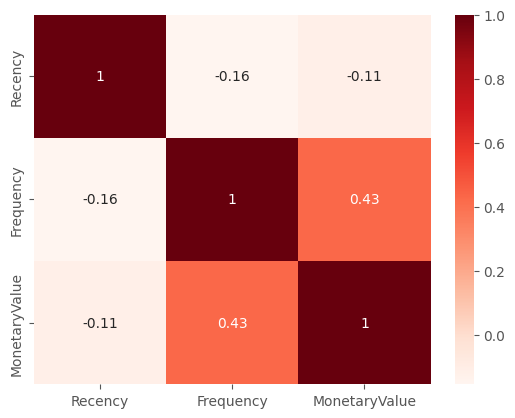

In [177]:
# Plot the heatmap of the feature correlations in the dataframe
sns.heatmap(rfm_data.corr(), annot = True, cmap = 'Reds');

- I picked this chart to show the correlation between different variables.

- The insight is that there is a negative correlation between recency and both frequency and monetary, indicating that customers who have recently made a purchase are less likely to make another purchase. There is also a positive but weak correlation between frequency and monetary.

- The insights can help create a positive business impact by helping businesses better understand customer behaviour and tailor their sales and promotions accordingly.

## **Plot the distribution of Recency, Frequency, and MonetaryValue**

A scatter matrix is a visual representation of the relationships between multiple variables or features in a dataset. It can help identify patterns, trends, and correlations between the variables. It is a useful tool for exploratory data analysis and can help provide insight into the data.

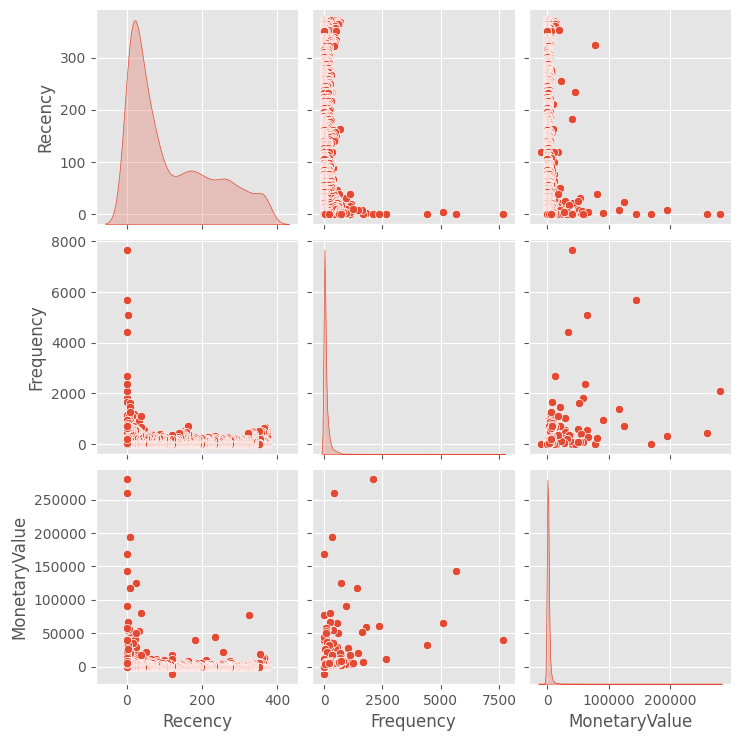

In [178]:
#Visualize the distribution of features in the dataset
sns.pairplot(rfm_data, diag_kind = 'kde');

- The pairplot with kde diagonal plots was chosen as it is an effective way to visualize the distribution and pairwise relationships between multiple features in a dataset. It allows us to quickly identify any correlations or patterns between variables, making it an excellent choice for visualizing the distribution of features in the dataset.

- We can observe that the distributions of the three variables are skewed. This suggests that normalization is necessary to make the data features normally distributed, as most clustering algorithms require them to be normally distributed.

In [179]:
#The skew() method is used to measure the asymmetry of the data around the mean.
rfm_data.skew()

Recency           0.821957
Frequency        18.241606
MonetaryValue    22.479109
dtype: float64

We can notice that we have a skewed distribution of the 3 variables and there exist outliers.

This indicates how normalization is required to make the data features normally distributed as clustering algorithms require them to be normally distributed.

## **Data Normalization**

For data normalization, logarithmic transformations were applied to the Recency and Monetary features, while a natural logarithmic transformation was applied to the Frequency feature. This was done to reduce the impact of outliers and to scale the data. A small constant value (0.1) was added to the original values before taking the logarithm to avoid taking the logarithm of zero or negative values.

In [180]:
# Calculate the logarithmic values of the Recency and Monetary features

# logarithmic value of the Recency feature
rfm_r_log = np.log(rfm_data['Recency'] + 0.1)

# logarithmic value of the Monetary feature
rfm_m_log = np.log(rfm_data['MonetaryValue'] + 0.1)


# calculate the natural log of the 'Frequency' column
rfm_f_log = np.log(rfm_data['Frequency'])

In [181]:
# Create a DataFrame containing logarithmic values of the Recency, Monetary and Frequency columns

log_data = pd.DataFrame({'Monetary' : rfm_m_log, 'Recency': rfm_r_log, 'Frequency': rfm_f_log})
#log_data = log_data.dropna(subset='Monetary')
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
123460,11.253944,5.784133,0.000000
123470,8.368716,0.741937,5.204007
123480,7.494063,4.318821,3.433987
123490,7.471733,2.895912,4.290459
123500,5.812637,5.736895,2.833213


In [182]:
log_data.isna().sum()

Monetary     2
Recency      0
Frequency    0
dtype: int64

In [183]:
log_data['Monetary'].fillna(log_data['Monetary'].median(), inplace=True)
log_data.isna().sum()

Monetary     0
Recency      0
Frequency    0
dtype: int64

**Plot the distribution of Recency, Frequency, and MonetaryValue after Data Normalization**

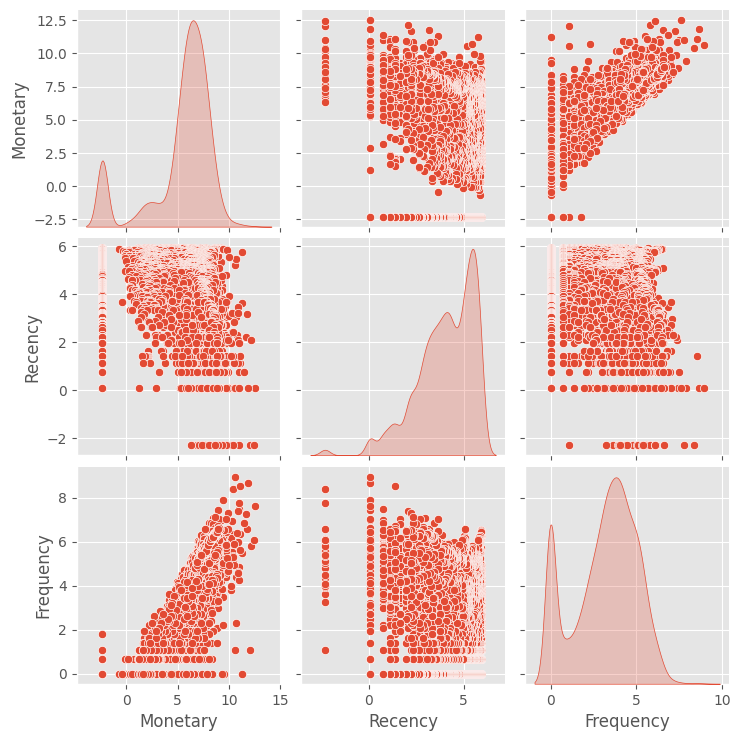

In [184]:
# Use seaborn's pairplot function to create a scatter matrix for each pair of features in the data

sns.pairplot(data = log_data, diag_kind = 'kde');

The distribution of the Frequency and Monetary features have improved and appear to be more normal, but the distribution of the Recency feature has only improved to some extent and is still not as well-normalized as the other two features.

In [185]:
# Calculate the skewness of each feature in the data
log_data.skew()

Monetary    -1.475822
Recency     -1.027708
Frequency   -0.390231
dtype: float64

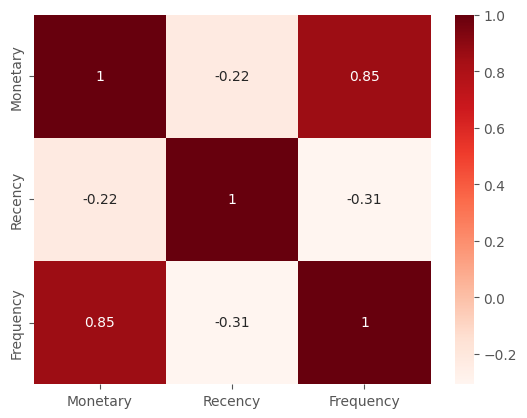

In [186]:
# Features correlation after log transformation or data normalization
sns.heatmap(log_data.corr(), annot = True, cmap = 'Reds');

The correlation between Monetary and Frequency is now stronger.

In [187]:
# use the corr method of the data frame to calculate the correlation matrix
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.221322,0.854420
Recency,-0.221322,1.000000,-0.306862
Frequency,0.854420,-0.306862,1.000000


In [188]:
# Assign the normalized data to a variable "X"
X = log_data

## **Data Scaling**

In [189]:
from sklearn.preprocessing import StandardScaler
# Define the features to use for K-means
features = ['Recency', 'Frequency', 'Monetary']

# Standardize the feature values
scaler = StandardScaler()
X = scaler.fit_transform(log_data[features].values)

We have used Standardization to transform my features in order to ensure that they had a similar scale and distribution. This was important because some machine learning algorithms are sensitive to the scale and distribution of features, and Standardization helps to ensure unbiased results.

## ***7. ML Model Implementation***

## **7.1. K-means Implementation**

- One of the common challenges when working with k-means is the need to specify the number of clusters beforehand. Determining the appropriate number of clusters is not always straightforward, and it can be difficult to deduce from the data alone. To tackle this challenge, a common approach is to try different numbers of clusters and evaluate their corresponding silhouette coefficients.

- The **Silhouette Coefficient** measures the similarity of a data point to its assigned cluster, ranging from -1 (indicating dissimilarity) to 1 (indicating similarity). By computing the silhouette coefficient for each data point, we can gauge how well it aligns with its assigned cluster. A higher silhouette coefficient suggests that the point is more similar to its cluster, indicating better clustering performance.

- Another method that can be used to determine the optimal number of clusters is the **Elbow method**. This technique involves plotting the number of clusters against the corresponding distortion or inertia (the sum of squared distances between each point and its centroid). The plot often resembles an "elbow" shape, and the number of clusters at the "elbow" is considered a good choice for the optimal cluster count.

- It's worth noting that k-means is sensitive to its initializations since they play a crucial role in the quality of the obtained solutions. To address this, a smart initialization technique called** k-means++** is commonly utilized. K-means++ intelligently selects initial cluster centroids, increasing the chances of finding better cluster arrangements. By leveraging k-means++ initialization, we enhance the algorithm's ability to converge to high-quality solutions.

### **7.1.1 K-Means with silhouette_score**

In [190]:
silhouette_scores = []

# Loop over different values of K
for n_clusters in range(2, 16):
  # Initialize the K-Means model with number of clusters
  kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters)

  # Fit the KMeans Model to the data
  kmeans.fit(X)

  # Predict the cluster labels for each data point
  labels = kmeans.labels_

  # Calculate the Silhouette score
  silhouette = silhouette_score(X, labels)

  # Append the silhouette_score to the array
  silhouette_scores.append(silhouette)

  # Print the silhouette score
  print(f'Silhouette score for {n_clusters} clusters: {silhouette:.3f}')


Silhouette score for 2 clusters: 0.481
Silhouette score for 3 clusters: 0.412
Silhouette score for 4 clusters: 0.340
Silhouette score for 5 clusters: 0.334
Silhouette score for 6 clusters: 0.358
Silhouette score for 7 clusters: 0.343
Silhouette score for 8 clusters: 0.341
Silhouette score for 9 clusters: 0.336
Silhouette score for 10 clusters: 0.340
Silhouette score for 11 clusters: 0.327
Silhouette score for 12 clusters: 0.331
Silhouette score for 13 clusters: 0.334
Silhouette score for 14 clusters: 0.333
Silhouette score for 15 clusters: 0.336


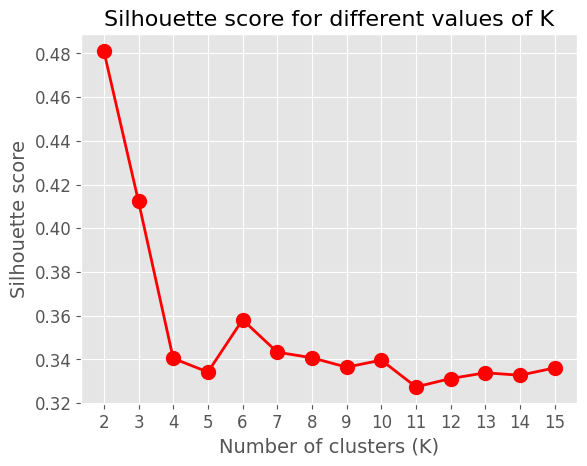

In [191]:
# Plot the silhouette scores
plt.plot(range(2, 16), silhouette_scores, '-o', color='red', markersize=10, linewidth=2)
plt.xlabel('Number of clusters (K)', fontsize=14)
plt.ylabel('Silhouette score', fontsize=14)
plt.title('Silhouette score for different values of K', fontsize=16)
plt.xticks(range(2, 16), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**The best silhouette score obtained is when the number of clusters is 2.**

In [192]:
# Instantiate a KMeans object with 2 clusters
kmeans = KMeans(n_clusters = 2)


# Fit the input data X to the Mean Model
kmeans.fit(X)

# Predict the cluster labels for the input data X using the trained KMeans model
y_kmeans = kmeans.predict(X)

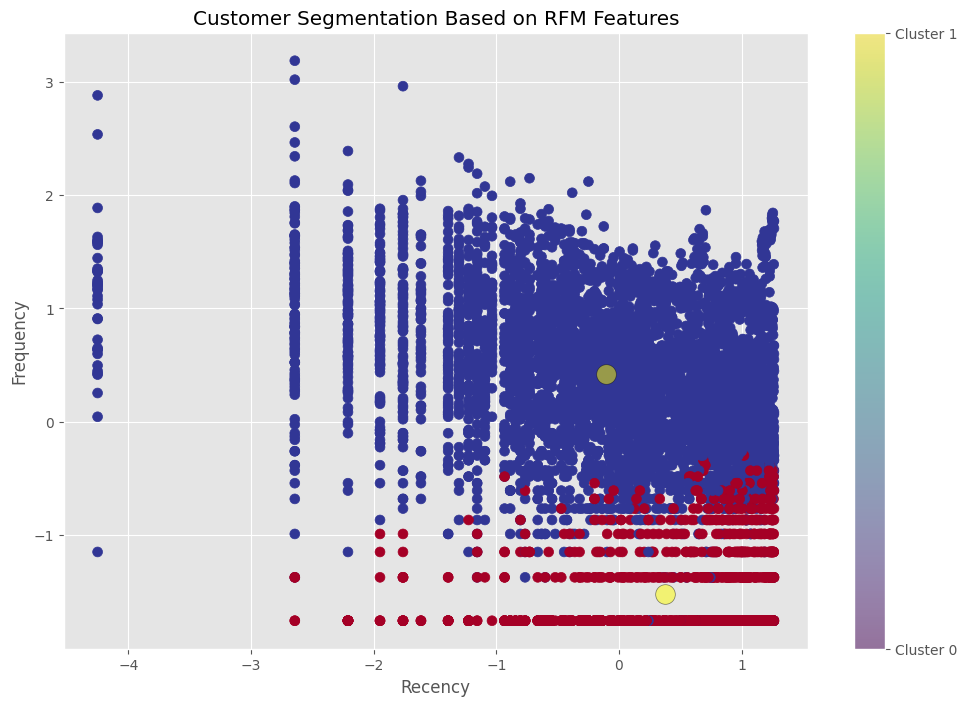

In [193]:
# Visualization of customer segmentation based On RFM features.
# Set the figure size and title for the scatter plot
plt.figure(figsize=(12,8))
plt.title('Customer Segmentation Based on RFM Features')

# Plot the scatter plot using the first two features of the input data X and the predicted cluster labels y_kmeans
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='RdYlBu')

# Get the cluster centers from the trained KMeans model and plot them as yellow circles with transparency
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='yellow', s=200, alpha=0.5, edgecolor='black')

# Set the x-axis and y-axis labels
plt.xlabel('Recency')
plt.ylabel('Frequency')

# Add a color bar to the plot to show the correspondence between the colors and the cluster labels
color_bar = plt.colorbar()
color_bar.set_ticks(np.unique(y_kmeans))
color_bar.set_ticklabels(['Cluster {}'.format(i) for i in np.unique(y_kmeans)])

# Show the plot
plt.show()

### **7.1.2 K-Means with Elbow method**

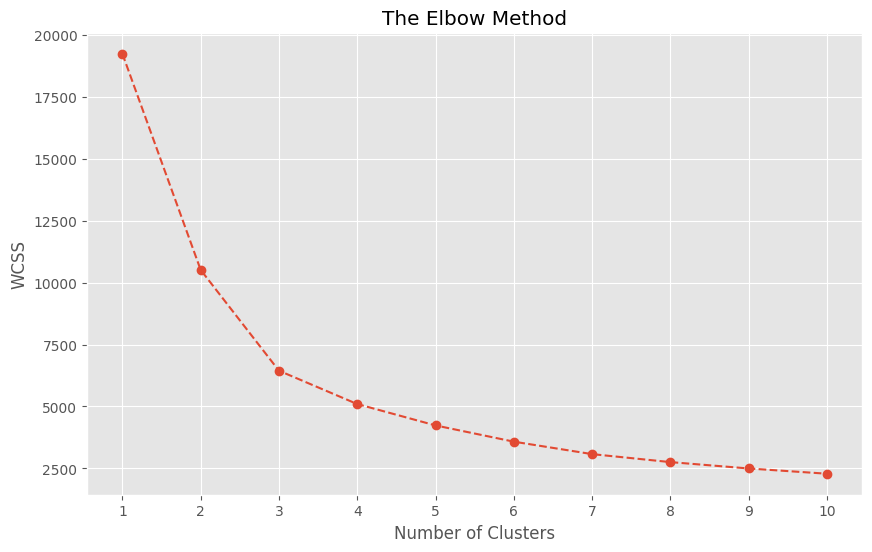

In [194]:
# Input data X

# Initialize an empty list to store the WCSS values for different number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)  # Create a KMeans instance for each number of clusters
    kmeans.fit(X)  # Fit the KMeans model to the input data X
    wcss.append(kmeans.inertia_)  # Append the WCSS value to the list for the current number of clusters

# Plot the WCSS values against the number of clusters
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()


**The Elbow Method plot is commonly used to identify the optimal number of clusters in a K-means clustering algorithm.**

In [195]:
rfm_df

,CustomerID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
0,123460,325,1,77183.60,1,1,4,114
1,123470,2,182,4310.00,4,4,4,444
2,123480,75,31,1797.24,2,2,4,224
3,123490,18,73,1757.55,4,3,4,434
4,123500,310,17,334.40,1,2,2,122
...,...,...,...,...,...,...,...,...
6408,581435,1,2,3.35,4,1,1,411
6409,581439,1,635,6637.59,4,4,4,444
6410,581492,0,731,7689.23,4,4,4,444
6411,581497,0,59,3217.20,4,3,4,434


In [196]:
# Create an instance of the KMeans model with 2 clusters and initialize the centroids using the 'k-means++' method
KMean_clust = KMeans(n_clusters= 2, init= 'k-means++', max_iter= 1000)

# Fit the KMeans model to the data in the X variable
KMean_clust.fit(X)

# Add a new column to the rfm_df dataframe to store the cluster labels for each observation
rfm_df['Cluster'] = KMean_clust.labels_

# Display the first 10 rows of the rfm_df dataframe with the new 'Cluster' column
rfm_df.head(10)

,CustomerID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,Cluster
0,123460,325,1,77183.60,1,1,4,114,0
1,123470,2,182,4310.00,4,4,4,444,0
2,123480,75,31,1797.24,2,2,4,224,0
3,123490,18,73,1757.55,4,3,4,434,0
4,123500,310,17,334.40,1,2,2,122,0
5,123520,36,85,2506.04,3,3,4,334,0
6,123530,204,4,89.00,1,1,1,111,1
7,123540,232,58,1079.40,1,3,3,133,0
8,123550,214,13,459.40,1,2,2,122,0
9,123560,22,59,2811.43,4,3,4,434,0


## **7.2 Agglomerative Hierarchial Clustering**

Agglomerative Hierarchical Clustering is a bottom-up approach that merges similar clusters until the desired number of clusters is achieved. It uses a distance/similarity measure between data points and can create a dendrogram to visualize the merging process. It captures hierarchical relationships but can be computationally expensive for large datasets and is not suitable for high-dimensional data.

In [197]:
# Import necessary libraries
from sklearn.cluster import AgglomerativeClustering

# Create an instance of AgglomerativeClustering with 2 clusters, euclidean affinity, and ward linkage
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

# Fit the input data X to the model
model.fit(X)

AgglomerativeClustering(affinity='euclidean')

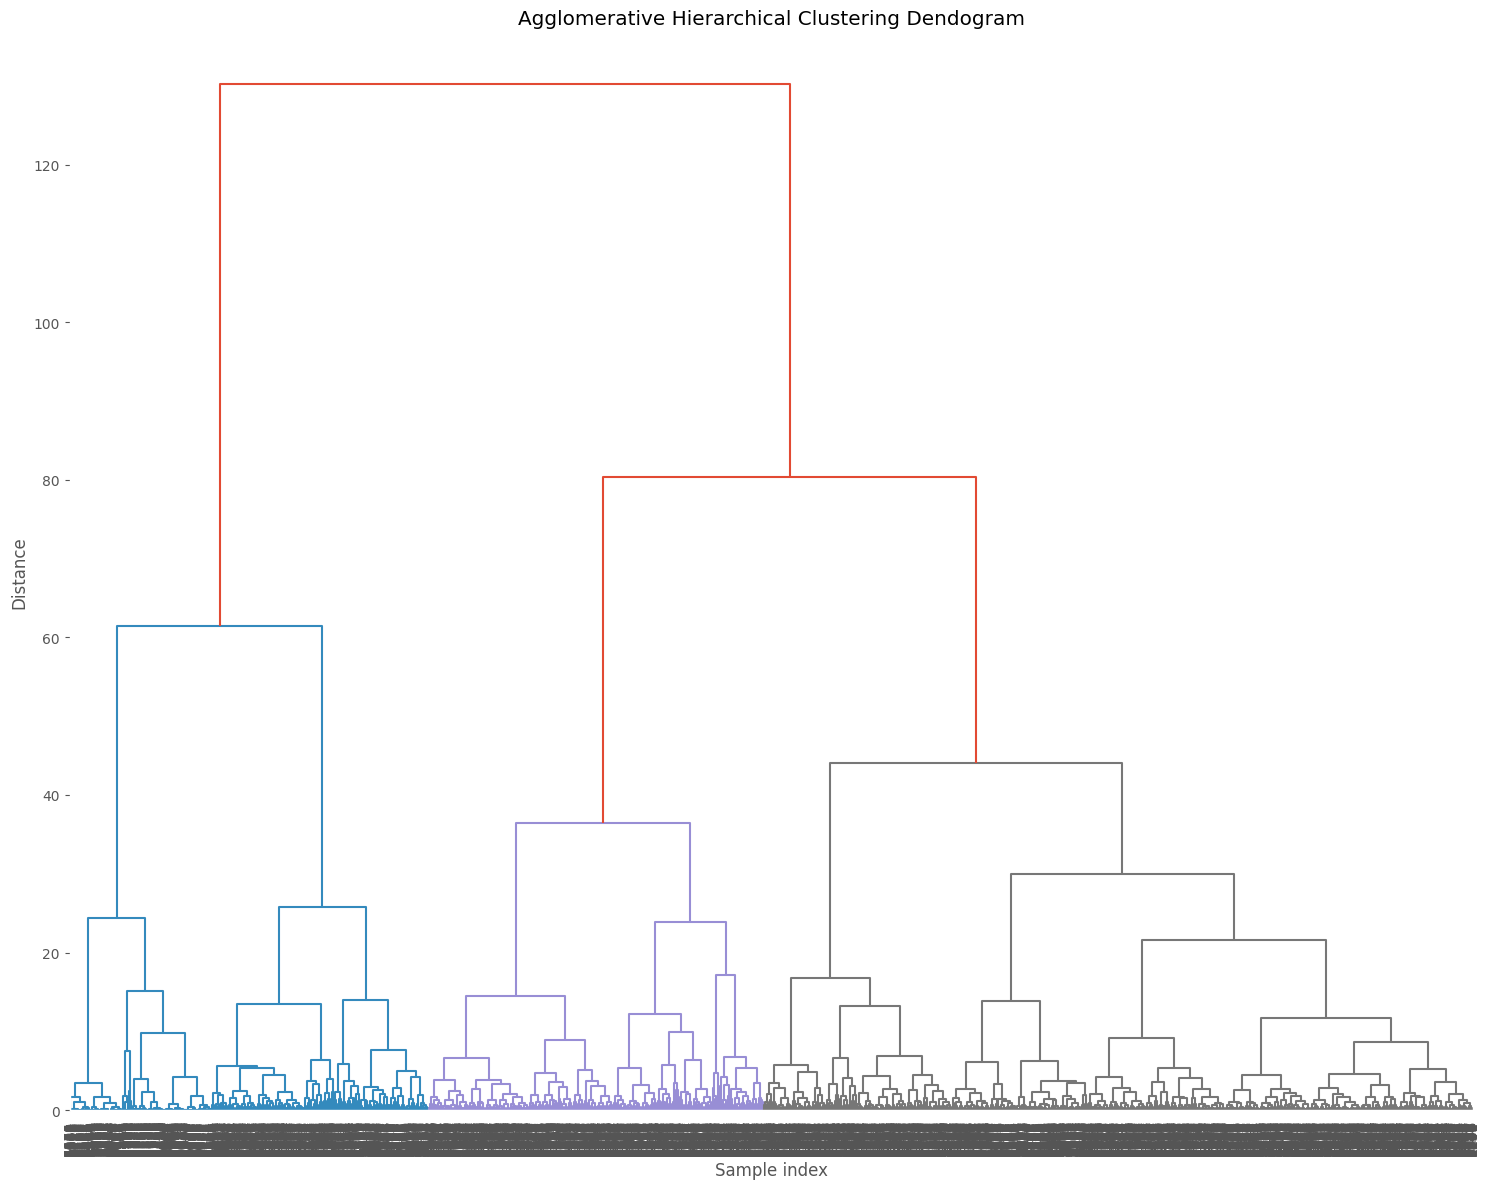

In [198]:
# Import necessary libraries
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Set the figure size and title for the dendrogram plot
plt.figure(figsize=(15, 12))
plt.title('Agglomerative Hierarchical Clustering Dendogram')

# Set the x and y-axis labels for the dendrogram plot
plt.xlabel('Sample index')
plt.ylabel('Distance')

# Create a linkage matrix using the input data X and the ward linkage method
Z = linkage(X, 'ward')

# Plot the dendrogram with specified parameters
dendrogram(Z, leaf_rotation=90.0, p=25, color_threshold=80, leaf_font_size=10, truncate_mode='level')

# Ensure tight layout of the plot
plt.tight_layout()

## **7.3 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

DBSCAN is a density-based clustering algorithm that groups data points based on their density in the feature space. It identifies clusters as dense regions separated by areas of lower density and is robust to noise and outliers. It doesn't require specifying the number of clusters in advance. Its parameters include the radius (Eps) and minimum number of points (MinPts) to form a core point.

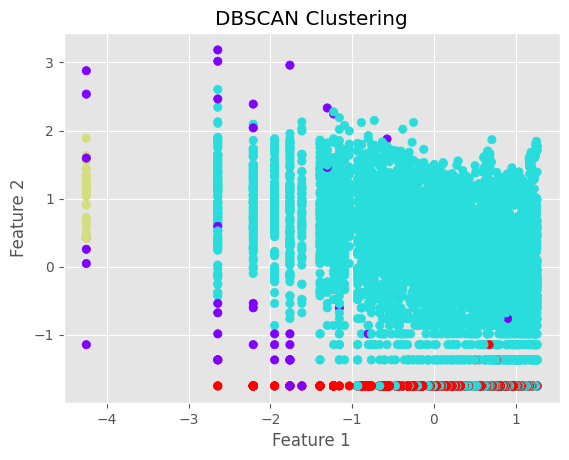

In [199]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=15)
dbscan.fit(X)

# Plot the results
plt.scatter(X[:,0], X[:,1], c=dbscan.labels_, cmap='rainbow')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

- The chart used is a scatter plot, which is a suitable choice for visualizing the clustering results of DBSCAN. The x and y axes represent the two features of the dataset, and the points are colored based on their assigned cluster labels.

- The insights gained from the chart include identifying the clusters formed by the DBSCAN algorithm and their density. The points that are closer to each other are assigned to the same cluster, and the outliers or noise points are labeled as -1. By observing the distribution of the points and the density of the clusters, we can understand the structure and characteristics of the data, and potentially find any patterns or anomalies.

- The gained insights can help in creating a positive business impact by identifying groups of similar data points, which can aid in targeting specific segments of customers or optimizing operational processes.

# **Summary Table**

In [200]:
# Import necessary libraries
from prettytable import PrettyTable

# Initialize the table with specified column names
myTable = PrettyTable(['SL No.', "Model_Name", 'Data', "Optimal_Number_of_cluster"])

# Add rows to the table
myTable.add_row(['1', "K-Means with silhouette_score", "RFM", "2"])
myTable.add_row(['2', "K-Means with Elbow method", "RFM", "2"])
myTable.add_row(['3', "Hierarchical clustering", "RFM", "2"])
myTable.add_row(['4',"DBSCAN ", "RFM", "3"])

# Print the table
print(myTable)

+--------+-------------------------------+------+---------------------------+
| SL No. |           Model_Name          | Data | Optimal_Number_of_cluster |
+--------+-------------------------------+------+---------------------------+
|   1    | K-Means with silhouette_score | RFM  |             2             |
|   2    |   K-Means with Elbow method   | RFM  |             2             |
|   3    |    Hierarchical clustering    | RFM  |             2             |
|   4    |            DBSCAN             | RFM  |             3             |
+--------+-------------------------------+------+---------------------------+


# **Conclusion**

**EDA**

- Null values and duplicates were removed from the dataset before applying clustering.

- Top customer IDs were found to be 17841.0, 14911.0, 14096.0, 12748.0, and 14606.0.

- The top five countries based on the percentage of total orders were the United Kingdom (88.95%), Germany (2.33%), France (1.84%), Ireland (1.84%), and Spain (0.62%).

- The top five products purchased based on frequency were White Hanging Heart T-Light Holder, Regency Cakestand 3 Tier, Jumbo Bag Red Retrospot, Party Bunting, and Assorted Colour Bird Ornament.

- The top stock codes based on count values were 85123A, 22423, 85099B, 47566, and 84879.

- New columns were created using InvoiceDate, such as Year, Month, Day, Hour, Month_Num, and Day_Num.

- The total amount of each order was calculated using the product of unit price and quantity.

- The months of November, October, December, September, and May generated the most business.

- The most popular purchasing days were Thursday, Wednesday, Tuesday, Monday, Saturday, and Friday.

- Most customers made purchases between 10:00 A.M. and 2:00 P.M.

- The top time duration for purchasing was found to be afternoon, followed by morning and evening.

The plots clearly indicates that green cluster is high value customer cohort (Cluster 1) and blue cluster is Lost/low value customer cohort (Cluster 2) while red cluster is average value customer cohort (Cluster 0)

High Value :- Frequent spending customers with high monetary transactions and had transacted recently

Low Value/ Lost :- Customers with least frequency and monetary spending and made purchase long time ago. These customers might be lost from the customer base.

Average Value :- Customers who made their transactions some time ago with less frequency and monetary value. These customers could become high risk and we could aggressively market towards them with great deals so we don't lose them forever.

#### On the basis of this analysis, the business can offer attractive deals to its average and low value customers and they can also treat their high value customers with special business offers such as loyalty points.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***